In [1]:
import matplotlib.pyplot as plt
import numpy as np            
import pandas as pd        
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Đường dẫn thư mục
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

# Các tham số
batch_size = 32 
img_height = 300
img_width = 300
epochs = 50

In [2]:
# Data augmentation for training
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]
)


# Data augmentation for testing/validation
test_data_gen = ImageDataGenerator(rescale=1./255)


In [3]:
# Training data generator
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Testing data generator
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# Validation data generator
validation_generator = image_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)

{'1_Normal': 0, '2_Disease': 1}


In [5]:
# Tính class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Load EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Thêm các lớp tùy chỉnh với regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Mở khóa các lớp cuối của base model để fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
61/61 [==============================] - 660s 10s/step - loss: 19.6429 - accuracy: 0.4467 - auc: 0.5170 - precision: 0.7268 - recall: 0.3649 - val_loss: 19.4957 - val_accuracy: 0.2897 - val_auc: 0.5170 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/50
61/61 [==============================] - 459s 8s/step - loss: 19.2853 - accuracy: 0.4967 - auc: 0.5128 - precision: 0.7305 - recall: 0.4713 - val_loss: 19.1053 - val_accuracy: 0.3018 - val_auc: 0.4991 - val_precision: 0.8750 - val_recall: 0.0198 - lr: 1.0000e-05
Epoch 3/50
61/61 [==============================] - 450s 7s/step - loss: 18.9327 - accuracy: 0.4920 - auc: 0.5326 - precision: 0.7263 - recall: 0.4670 - val_loss: 18.7509 - val_accuracy: 0.6097 - val_auc: 0.5532 - val_precision: 0.7143 - val_recall: 0.7507 - lr: 1.0000e-05
Epoch 4/50
61/61 [==============================] - 446s 7s/step - loss: 18.5949 - accuracy: 0.5075 - auc: 0.5266 - precision: 0.7362 - recall: 0.4871 - val_loss: 18.414

In [6]:
model.save('EfficientNetB3_model.h5')

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
#Đánh giá model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test)
print('Test accuracy:', test_acc)
print('Test AUC:', test_auc)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)

# Dự đoán và metrics
y_pred_proba = model.predict(test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Có thể điều chỉnh ngưỡng này
y_true = test.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

# Tính toán metrics
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')


20/20 [==============================] - 33s 2s/step - loss: 7.2656 - accuracy: 0.7905 - auc: 0.8435 - precision: 0.8357 - recall: 0.8599
Test accuracy: 0.7905073761940002
Test AUC: 0.8435224294662476
Test Precision: 0.8356807231903076
Test Recall: 0.8599033951759338
20/20 [==============================] - 34s 2s/step
Confusion Matrix:
[[127  70]
 [ 58 356]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.69      0.64      0.66       197
     Disease       0.84      0.86      0.85       414

    accuracy                           0.79       611
   macro avg       0.76      0.75      0.76       611
weighted avg       0.79      0.79      0.79       611

ROC AUC Score: 0.8435
Sensitivity: 85.99%
Specificity: 64.47%
F1-Score: 0.85


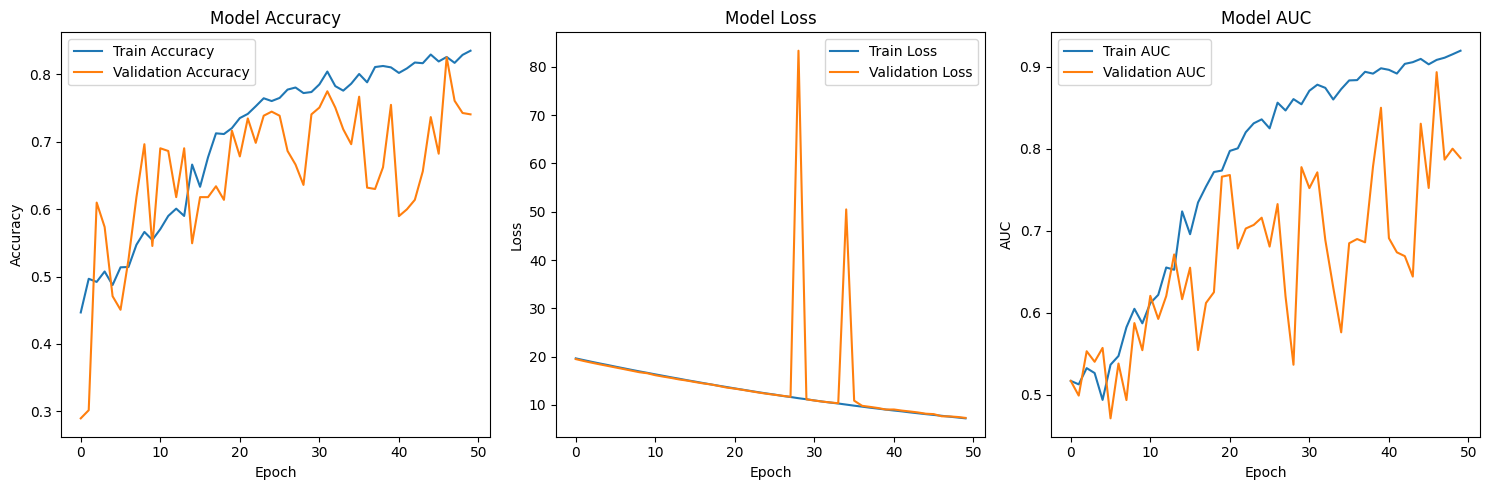

In [10]:
# Vẽ đồ thị lịch sử huấn luyện
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()





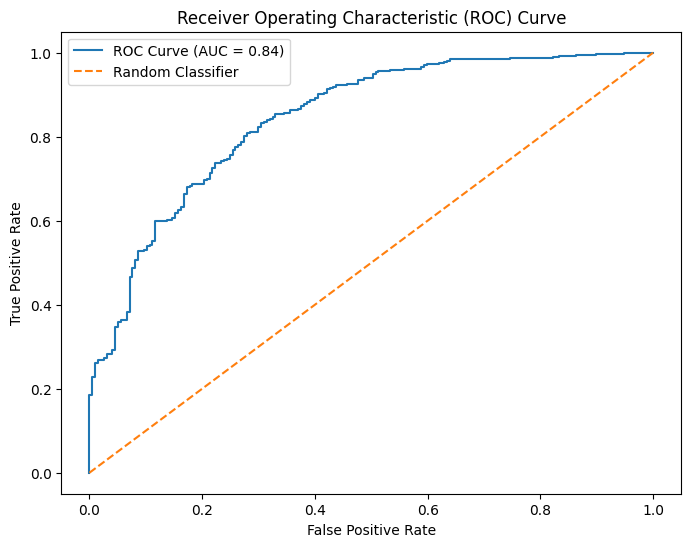

In [11]:
# Vẽ đồ thị ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
